### Import packages

In [1]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.states.statevector import Statevector
from qiskit.quantum_info import DensityMatrix
from math import pi
import numpy as np
from qiskit.circuit.library.standard_gates import RYGate
import matplotlib.pyplot as plt

### Flexible Representation of Quantum Images (FRQI)

In [2]:
def get_U(n, thetas):
    qr = QuantumRegister(n+1)
    qc = QuantumCircuit(qr)
    
    binary = []

    n_pixels = 2**n

    for i in range(n_pixels): 
            binary.append(f'{i:0{int(np.log2(n_pixels))}b}')

    RY_gate = RYGate(theta=2*thetas[0]).control(n)

    for i in range(n):
        qc.h(i)

    qc.barrier()
    
    qc.append(RY_gate, qr)

    qc.barrier()

    for j in range(n_pixels-1):
        ls_prev = binary[j]
        ls_next = binary[j+1]
    
        for i in range(n):
            if int(ls_prev[i]) == 0 and int(ls_next[i]) == 1:
                qc.x(i)
            
            if int(ls_prev[i]) == 1 and int(ls_next[i]) == 0:
                qc.x(i)
                
        RY_gate = RYGate(theta=2*thetas[j+1]).control(n)

        qc.append(RY_gate, qr)
 
        qc.barrier()
    
    return qc

### Compute fidelity: statevector vs shotnoise

In [3]:
def statevector_fidelity(U_ref, U_trial, n): 
    state_ref = np.array(Statevector(U_ref))
    state_trial = np.array(Statevector(U_trial))
    
    return state_ref.conj().T @ state_trial

def statevector_L2(U_ref, U_trial, n, n_shots): 
    state_ref = np.array(Statevector(U_ref))
    state_trial = np.array(Statevector(U_trial))

    return np.sum(np.absolute(state_ref - state_trial)**2)


In [4]:
def shotnoise_fidelity(U_ref, U_trial, n, n_shots): 
    qc = U_ref.compose(U_trial.inverse())
    qc.measure_all()
    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=n_shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)

    
    if str('0'*(n+1)) in counts and str('1'+'0'*(n)) in counts: 
        return (counts['0'*(n+1)] + counts['1' + '0'*(n)])/n_shots
    if str('0'*(n+1)) in counts and str('1'+'0'*(n)) not in counts:
        return (counts['0'*(n+1)])/n_shots
    if str('0'*(n+1)) not in counts and str('1'+'0'*(n)) in counts:
        return (counts['1'+'0'*(n)])/n_shots


### Load the image dataset

In [6]:
img_refs = []
img_trial_similars = []
img_trial_differents = []

n_images = 30

for i in range(n_images): 
    img_ref = np.array(np.load(f"Preprocessed_Dataset/Train_set/one_ref/ref.npy")).reshape(16, 16)
    img_refs = np.array(np.load(f"Preprocessed_Dataset/Train_set/many_ref/ref {i+1}.npy")).reshape(16, 16)
    img_trial_similars.append(np.load(f"Preprocessed_Dataset/Test_set/Similar/yes {i+1}.npy").reshape(16, 16))
    img_trial_differents.append(np.load(f"Preprocessed_Dataset/Test_set/Different/non {i+1}.npy").reshape(16, 16))
    
img_trial_similars = np.array(img_trial_similars)
img_trial_differents = np.array(img_trial_differents)

Text(0.5, 1.0, 'Different')

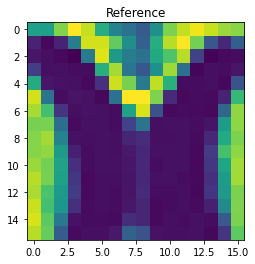

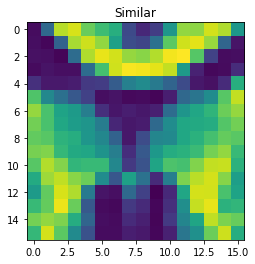

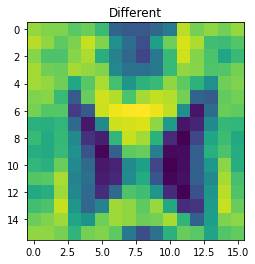

In [7]:
fig, ax = plt.subplots()
ax.imshow(img_ref)
ax.set_title("Reference")

fig, ax = plt.subplots()
ax.imshow(img_trial_similars[0])
ax.set_title("Similar")

fig, ax = plt.subplots()
ax.imshow(img_trial_differents[0])
ax.set_title("Different")


### Patch trick

In [8]:
def get_patches(img, patch_side): 
    img_patches = []
    patch_size = patch_side**2
    n_patches = img.shape[0]//patch_side
    for i in range(n_patches): 
        for j in range(n_patches):
            img_patches.append(img[i*patch_side:(i+1)*patch_side, j*patch_side:(j+1)*patch_side])
        
    return np.array(img_patches)

### Fidelity (statevector)

In [9]:
def statevector_fidelity_patches(imgref_patches, imgtrial_patches):
    cfids = []
    tds = []
    
    for i in range(imgref_patches.shape[0]): 
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()
        
        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = statevector_fidelity(U_ref, U_trial, n)
        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))
    
    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_mean_similars = []
td_mean_differents = []

for i in range(n_images):
    imgref_patches = get_patches(img_ref, 2)
    imgtrialsimilar_patches = get_patches(img_trial_similars[i], 2)
    imgtrialdifferent_patches = get_patches(img_trial_differents[i], 2)
    
    cfids_similar, tds_similar = statevector_fidelity_patches(imgref_patches, imgtrialsimilar_patches)
    cfids_different, tds_different = statevector_fidelity_patches(imgref_patches, imgtrialdifferent_patches)

    td_mean_similars.append(np.mean(tds_similar, axis = 0))
    td_mean_differents.append(np.mean(tds_different, axis = 0))

#### Plotting

C:\Users\Utente\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Figure')

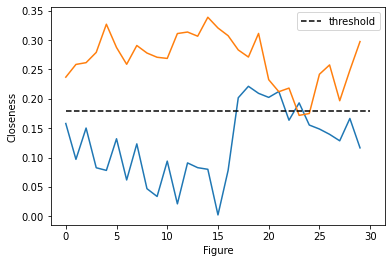

In [10]:
plt.plot(td_mean_similars, label = 'Similar')
plt.plot(td_mean_differents, label = 'Different')
plt.hlines(0.18, 0, n_images, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")

### Fidelity (shotnoise)

In [12]:
def shotnoise_fidelity_patches(imgref_patches, imgtrial_patches, n_shots):
    cfids = []
    tds = []
    
    for i in range(imgref_patches.shape[0]): 
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()
        
        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = shotnoise_fidelity(U_ref, U_trial, n, n_shots)

        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))
    
    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_mean_similars = []
td_mean_differents = []
n_shots = 100000

for i in range(n_images):
    imgref_patches = get_patches(img_ref, 2)
    imgtrialsimilar_patches = get_patches(img_trial_similars[i], 2)
    imgtrialdifferent_patches = get_patches(img_trial_differents[i], 2)
    
    cfids_similar, tds_similar = shotnoise_fidelity_patches(imgref_patches, imgtrialsimilar_patches, n_shots)
    cfids_different, tds_different = shotnoise_fidelity_patches(imgref_patches, imgtrialdifferent_patches, n_shots)

    td_mean_similars.append(np.mean(tds_similar, axis = 0))
    td_mean_differents.append(np.mean(tds_different, axis = 0))
    

Text(0.5, 0, 'Figure')

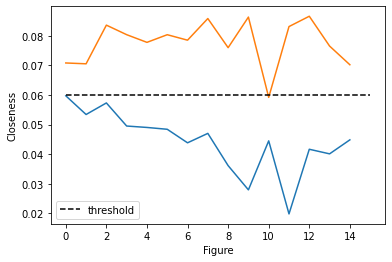

In [16]:
plt.plot(td_mean_similars[:15], label = 'Similar')
plt.plot(td_mean_differents[:15], label = 'Different')
plt.hlines(0.060, 0, 15, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")

### Mean image trick

In [ ]:
def quantum_fidelity_patches(imgref_patches, imgtrial_patches, n_shots):
    cfids = []
    tds = []
    
    for i in range(imgref_patches.shape[0]): 
        imgref = imgref_patches[i]
        imgtrial = imgtrial_patches[i]

        theta_ref = imgref.flatten()
        theta_trial = imgtrial.flatten()
        
        n = int(np.log2(theta_ref.size))

        U_ref = get_U(n, theta_ref)
        U_trial = get_U(n, theta_trial)

        cfid = quantum_fidelity(U_ref, U_trial, n, n_shots)

        cfids.append(cfid)
        tds.append(2*(1-np.sqrt(cfid)))
    
    cfids = np.array(cfids)
    tds = np.array(tds)

    return cfids, tds

td_meanimage_similars = []
td_meanimage_differents = []
n_shots = 100000

img_ref = np.mean(img_refs, axis = 0)
imgref_patches = get_patches(img_ref, 2)
imgtrialsimilar_patches = get_patches(img_trial_similar_mean, 2)
imgtrialdifferent_patches = get_patches(img_trial_different_mean, 2)

cfids_similar, tds_similar = quantum_fidelity_patches(imgref_patches, imgtrialsimilar_patches, n_shots)
cfids_different, tds_different = quantum_fidelity_patches(imgref_patches, imgtrialdifferent_patches, n_shots)

td_meanimage_similars = np.mean(tds_similar, axis = 0)
td_meanimage_differents = np.mean(tds_different, axis = 0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Figure')

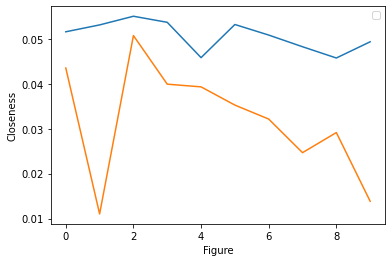

In [859]:
plt.plot(td_mean_similars, label = 'Similar')
plt.plot(td_mean_differents, label = 'Different')
plt.hlines(0.18, 0, n_images, label='threshold', linestyle='dashed', color='black')

plt.legend()
plt.ylabel("Closeness")
plt.xlabel("Figure")